## Package Installation and device checking

In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
from typing import List
device = "cuda" if torch.cuda.is_available() else "cpu"

## Interleaving Tokenization Method (Garg et al., 2022)

In training GPT-2, we consider an alternative tokenization method called **Interleave**, where the features `x` and `y` are interleaved into separate tokens.

### Tokenization Process:
E(P) =
\begin{pmatrix}
x_1 & 0 & x_2 & 0 & \cdots & x_N & 0 & x_{query} \\
0 & y_1 & 0 & y_2 & \cdots & 0 & y_N & 0
\end{pmatrix} \in \mathbb{R}^{(d+1)\times(2N+1)}

### Causal Masking:
To ensure that the i-th column only depends on the columns ≤ i, **causal masking** is used. This allows the formulation of a next-token prediction averaged across all `N` pairs of examples, with the following loss function:

$$
\hat{L}(\theta) = \frac{1}{2B} \sum_{\tau=1}^{B} \left( \frac{1}{N} \sum_{i=1}^{N} \left( f^{Mask}(E_{\tau}; \theta)_{d+1,2i+1} - y_{\tau,i+1} \right)^2 \right)
$$

### Reference:
This formulation was originally used in the work by **Garg et al. (2022)**.


In [2]:
class LoRALayer:
    def __init__(self, r: int, lora_alpha: int, lora_dropout: float):
        self.r = r
        self.lora_alpha = lora_alpha
        self.lora_dropout = nn.Dropout(p=lora_dropout) if lora_dropout > 0. else lambda x: x

# class LoRAcAttnWrapper(nn.Module):
#     def __init__(self, lora_adapter_q, lora_adapter_k, original_v):
#         super().__init__()
#         self.lora_adapter_q = lora_adapter_q
#         self.lora_adapter_k = lora_adapter_k
#         self.original_v = original_v

#     def forward(self, x):
#         q = self.lora_adapter_q(x)
#         k = self.lora_adapter_k(x)
#         v = self.original_v(x)
#         return torch.cat([q, k, v], dim=-1)

class LoRAcAttnWrapper(nn.Module):
    def __init__(self, lora_adapter_q, lora_adapter_k, original_v, bias_q, bias_k, bias_v):
        super().__init__()
        self.lora_adapter_q = lora_adapter_q
        self.lora_adapter_k = lora_adapter_k
        self.original_v = original_v

        # Bias terms
        self.bias_q = nn.Parameter(bias_q)
        self.bias_k = nn.Parameter(bias_k)
        self.bias_v = nn.Parameter(bias_v)

    def forward(self, x):
        q = self.lora_adapter_q(x) + self.bias_q
        k = self.lora_adapter_k(x) + self.bias_k
        v = self.original_v(x) + self.bias_v
        return torch.cat([q, k, v], dim=-1)


class LoRAAdapter(nn.Module, LoRALayer):
    def __init__(
        self,
        existing_layer: nn.Module,
        in_features,
        out_features,
        r: int = 0,
        lora_alpha: int = 1,
        lora_dropout: float = 0.,
    ):
        nn.Module.__init__(self)
        LoRALayer.__init__(self, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout)
        self.existing_layer = existing_layer

        existing_dtype = next(existing_layer.parameters()).dtype
        if r > 0:
            self.lora_A = nn.Parameter(torch.zeros((in_features, r), dtype=existing_dtype))
            self.lora_B = nn.Parameter(torch.zeros((r, out_features), dtype=existing_dtype))
            self.scaling = self.lora_alpha / self.r
            self.reset_parameters()

    def reset_parameters(self):
        if hasattr(self, 'lora_A'):
            nn.init.normal_(self.lora_A, mean=0, std=0.02)
        if hasattr(self, 'lora_B'):
            nn.init.zeros_(self.lora_B)

    def forward(self, x: torch.Tensor):
        if self.r > 0:
            return self.existing_layer(x) + (self.lora_dropout(x) @ self.lora_A @ self.lora_B) * self.scaling
        else:
            return self.existing_layer(x)

def replace_c_attn_with_lora(model: nn.Module, r: int, lora_alpha: int, lora_dropout: float):
    for name, module in model.named_modules():
        if "c_attn" in name:
            # Extract original c_attn module
            original_layer = module
            in_features, out_features = original_layer.weight.shape
            hidden_dim = out_features // 3  # Split into Q, K, V

            original_bias = original_layer.bias
            bias_q = original_bias[:hidden_dim].detach().clone()
            bias_k = original_bias[hidden_dim:2 * hidden_dim].detach().clone()
            bias_v = original_bias[2 * hidden_dim:].detach().clone()

            # LoRA for Q and K
            lora_adapter_q = LoRAAdapter(
                existing_layer=nn.Linear(in_features, hidden_dim, bias=False),
                in_features=in_features,
                out_features=hidden_dim,
                r=r,
                lora_alpha=lora_alpha,
                lora_dropout=lora_dropout
            )
            lora_adapter_k = LoRAAdapter(
                existing_layer=nn.Linear(in_features, hidden_dim, bias=False),
                in_features=in_features,
                out_features=hidden_dim,
                r=r,
                lora_alpha=lora_alpha,
                lora_dropout=lora_dropout
            )

            # Keep V as is
            original_v = nn.Linear(in_features, hidden_dim, bias=False)
            original_v.weight = nn.Parameter(original_layer.weight[:, 2 * hidden_dim:])

            # Combine Q, K, and V with LoRA modifications
            # lora_c_attn_module = LoRAcAttnWrapper(lora_adapter_q, lora_adapter_k, original_v)
            lora_c_attn_module = LoRAcAttnWrapper(lora_adapter_q, lora_adapter_k, original_v, bias_q, bias_k, bias_v)


            # Replace c_attn module
            parts = name.split(".")
            parent = model
            for part in parts[:-1]:
                parent = getattr(parent, part)
            # print(parent)
            # print(parts[-1])
            # print(lora_c_attn)
            # setattr(parent, parts[-1], lora_c_attn)
            setattr(parent, parts[-1], lora_c_attn_module)


# Mark only LoRA parameters as trainable
def mark_only_lora_as_trainable(model: nn.Module):
    for name, param in model.named_parameters():
        if "lora_A" in name or "lora_B" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

In [3]:
from transformers import GPT2Model, GPT2Config
# GPT2 Model with LoRA
class MyGPT2Model(nn.Module):
    def __init__(self, input_dim, output_dim, embed_dim=256, num_layers=8, num_heads=4):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, embed_dim)
        self.output_layer = nn.Linear(embed_dim, output_dim)
        # Inject LoRA into c_attn layers
        # Initialize GPT-2 with custom configuration
        config = GPT2Config(
            n_embd=embed_dim,
            n_layer=num_layers,
            n_head=num_heads,
            vocab_size=50257  # Default GPT-2 vocab size
        )
        self.gpt2 = GPT2Model(config)
        replace_c_attn_with_lora(self.gpt2, r=8, lora_alpha=8, lora_dropout=0.1)

        # Mark only LoRA parameters as trainable
        mark_only_lora_as_trainable(self.gpt2)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.gpt2(inputs_embeds=x).last_hidden_state
        x = self.output_layer(x)
        return x

## Dataset setup

In [4]:

class MyDataset(torch.utils.data.Dataset):
    """ y = W * x, where w ~ N(0,I) and x ~ U(-1,1) """
    def __init__(self, x_dim, y_dim, len, L=None):
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.len = len
        self.L = 4 * max(x_dim, y_dim) if L is None else L

    def __len__(self):
        return self.len

    def __getitem__(self, _):
        d = max(self.x_dim, self.y_dim)
        x = torch.rand(self.L, self.x_dim) * 2 - 1 # (num_samples, x_dim)
        w = torch.randn(self.x_dim, self.y_dim) / (d ** 0.5)
        y = x @ w
        return x, y, w

## General training setups

In [ ]:
x_dim, y_dim, embed_dim = 12, 1, 256
num_layers, num_heads = 6, 2
bsize, num_steps = 64, 50000
lr, weight_decay = 1e-4, 1e-8
dataset = MyDataset(x_dim, y_dim, bsize * num_steps, L=64)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bsize)

## Training GPT2

Here we adopt the interleaving method from Garg et al. 2022. Here is the demonstration:

In [6]:
# config = GPT2Config(
#     n_embd=256,
#     n_layer=8,
#     n_head=4,
#     vocab_size=50257  # Default GPT-2 vocab size
# )
# t_model = GPT2Model(config)
# for name, param in t_model.named_parameters():
#     print(f"{name}: {param.shape}")

In [7]:
model = MyGPT2Model(x_dim+y_dim, x_dim+y_dim).train().to(device)
# for name, param in model.named_parameters():
#     print(f"{name}: {param.shape}")
# total_params = sum(p.numel() for p in model.parameters())
# trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# print(f"Total Parameters: {total_params}")
# print(f"Trainable Parameters: {trainable_params}")

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

epoch_losses = []
batch_losses = []

pbar = tqdm(dataloader)
for (x, y, w) in pbar:
    x, y = x.to(device), y.to(device)
    L = x.size(1)

    x_big = torch.cat([x, torch.zeros(bsize, L, y_dim, device=device)], dim=2)
    y_big = torch.cat([torch.zeros(bsize, L, x_dim, device=device), y], dim=2)
    # y_big[:,-1,-y_dim:] = 0.

    z = torch.cat([x_big, y_big], dim=2).view(bsize,2*L,x_dim+y_dim)

    # y_big = torch.cat([y, torch.zeros(bsize, y.size(1), x_dim - y_dim, device=device)], dim=-1)
    # z = torch.stack([x, y_big], dim=2).view(bsize, 2 * x.size(1), x_dim).to(device)

    # z: (bsize, 2L, x_dim+y_dim)
    # out: (bsize, 2L, x_dim+y_dim)
    out = model(z)
    y_pred = out[:, 0::2, -y_dim:]

    # print(f"out {out.shape}, y_pred {y_pred.shape}, y {y.shape}")

    loss = torch.nn.functional.mse_loss(y, y_pred)
    batch_losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    pbar.set_description(f"loss: {loss.item():.3e}")

avg_epoch_loss = sum(batch_losses) / len(batch_losses)
epoch_losses.append(avg_epoch_loss)
print(f"average loss: {avg_epoch_loss:.4f}")


loss: 3.501e-01:   8%|▊         | 1525/20000 [08:16<1:40:16,  3.07it/s]


KeyboardInterrupt: 

In [ ]:
out.shape

torch.Size([64, 128, 15])

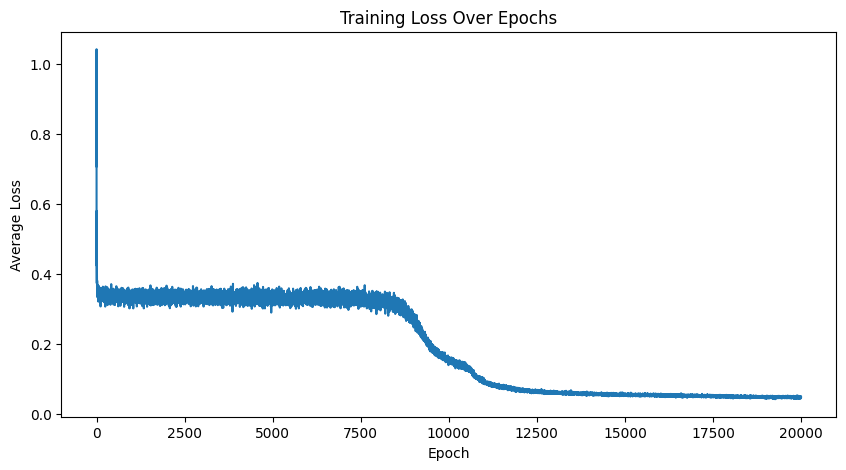

In [ ]:
# plot loss curve
import numpy as np
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(batch_losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.show()
plt.savefig("training_loss_curve.png", dpi=300, bbox_inches='tight')

Now, having a trained model, we want to check its in-context learning behavior. By having two weight vectors $w_1, w_2$, we hope to shuffle the portions of the two weight vectors in the in context prompt.

In [ ]:
def test_in_context_learning(model, x_dim, y_dim, num_runs=50, L=50):
    model.eval()
    device = next(model.parameters()).device
    mse_loss = nn.MSELoss(reduction='mean')

    proportions = np.arange(0, 1.1, 0.1)  # 0 to 1.0 in steps of 0.1
    all_losses_w1 = []
    all_losses_w2 = []

    for _ in range(num_runs):
        losses_w1 = []
        losses_w2 = []

        for prop in proportions:
            num1 = int(L * prop)
            num2 = L - num1

            ds1 = MyDataset(x_dim, y_dim, 1, L=num1)
            ds2 = MyDataset(x_dim, y_dim, 1, L=num2)

            x1, y1, w1 = ds1[0]
            x2, y2, w2 = ds2[0]

            x1, y1, w1 = x1.to(device), y1.to(device), w1.to(device)
            x2, y2, w2 = x2.to(device), y2.to(device), w2.to(device)

            xs = torch.cat([x1, x2], dim=0)
            ys = torch.cat([y1, y2], dim=0)

            perm = torch.randperm(L, device=device)
            xs = xs[perm]
            ys = ys[perm]

            xs_big = torch.cat([xs, torch.zeros(L, y_dim, device=device)], dim=-1)
            ys_big = torch.cat([torch.zeros(L, x_dim, device=device), ys], dim=-1)

            # Interelaved
            zs_big = torch.cat([xs_big, ys_big], dim=-1).view(2*L, x_dim+y_dim)

            # both w1 and w2
            x_test = torch.rand(x_dim, device=device) * 2 - 1
            y_true_w1 = x_test @ w1
            y_true_w2 = x_test @ w2
            # y_guess = prop * y_true_w1 + (1 - prop) * y_true_w2
            y_guess = torch.zeros(y_dim, device=device)

            x_test_big = torch.cat([x_test, torch.zeros(y_dim, device=device)], dim=0).view(1, x_dim+y_dim)
            y_test_big = torch.cat([torch.zeros(1, x_dim, device=device), y_guess.view(1,y_dim)], dim=1)
            zs_test = torch.cat([x_test_big, y_test_big], dim=0)

            zs_all = torch.cat([zs_big, zs_test.view(2,x_dim+y_dim)], dim=0)

            # print(f"zs_all {zs_all.shape}")
            # print(zs_all)
            # break

            # Get model predictions
            with torch.no_grad():
                out = model(zs_all.view(1, 2*L + 2, x_dim+y_dim))

            y_pred = out[0, -2, -y_dim:]

            loss_w1 = mse_loss(y_pred, y_true_w1).item()
            loss_w2 = mse_loss(y_pred, y_true_w2).item()

            # print(loss_w1, loss_w2)
            # break

            losses_w1.append(loss_w1)
            losses_w2.append(loss_w2)

        # print(losses_w1)
        # print(losses_w2)
        # break
        all_losses_w1.append(losses_w1)
        all_losses_w2.append(losses_w2)

    # Calculate average losses across all runs
    # print(all_losses_w1)
    avg_losses_w1 = np.mean(all_losses_w1, axis=0)
    avg_losses_w2 = np.mean(all_losses_w2, axis=0)

    return avg_losses_w1, avg_losses_w2

# Run the test
avg_losses_w1, avg_losses_w2 = test_in_context_learning(model, x_dim, y_dim)

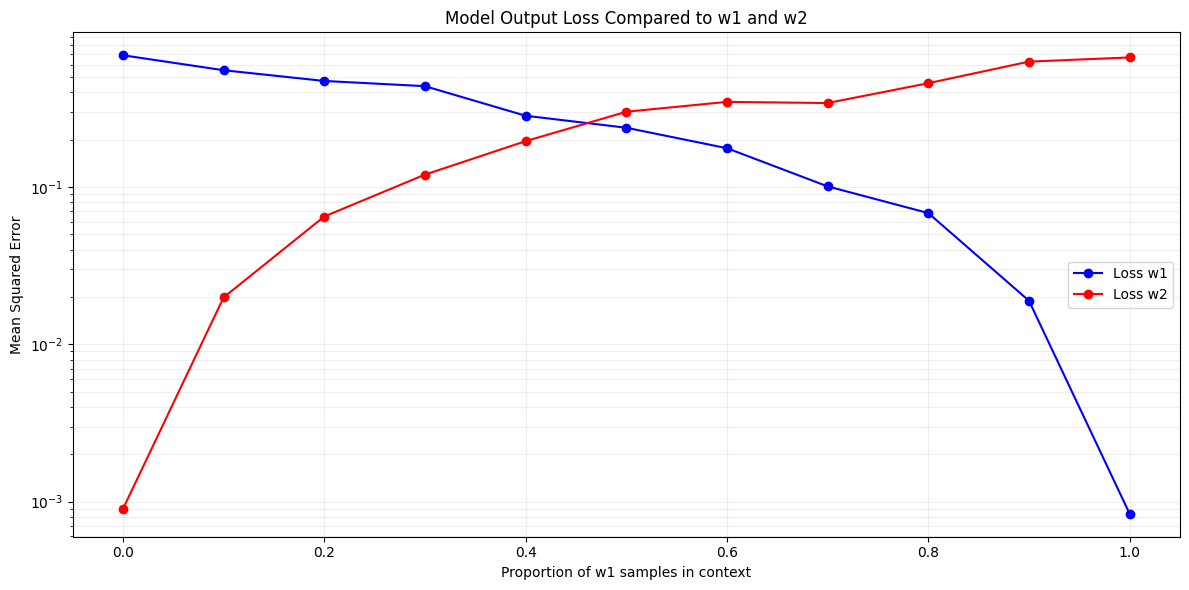

Average losses for w1: ['0.6886', '0.5531', '0.4727', '0.4380', '0.2840', '0.2383', '0.1765', '0.1010', '0.0683', '0.0189', '0.0008']
Average losses for w2: ['0.0009', '0.0199', '0.0649', '0.1199', '0.1958', '0.3011', '0.3480', '0.3421', '0.4574', '0.6275', '0.6668']


In [ ]:
proportions = np.arange(0, 1.1, 0.1)  # 0 to 1.0 in steps of 0.1

plt.figure(figsize=(12, 6))
plt.plot(proportions, avg_losses_w1, label='Loss w1', color='blue', marker='o')
plt.plot(proportions, avg_losses_w2, label='Loss w2', color='red', marker='o')
plt.xlabel('Proportion of w1 samples in context')
plt.ylabel('Mean Squared Error')
plt.title('Model Output Loss Compared to w1 and w2')
plt.legend()
plt.yscale('log')  # Use log scale for y-axis to better visualize differences
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.show()

print("Average losses for w1:", [f"{loss:.4f}" for loss in avg_losses_w1])
print("Average losses for w2:", [f"{loss:.4f}" for loss in avg_losses_w2])

